In [1]:
import os
import glob
import random

INSTR_PATH = os.path.join(os.getcwd(),"afi_txt")

In [2]:
from concurrent.futures import ThreadPoolExecutor, wait, as_completed
def do_fn_on_iter(fn, iterator, num_threads=6):
    futures = []
    if isinstance(num_threads, str):
        num_threads = int(num_threads)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        for elem in iterator:
            futures.append(executor.submit(fn, elem))
    results = []
    for x in as_completed(futures):
        results.append(x.result())
    return results


In [3]:
def get_file_list(limit=500, shuffle=True):
    files = glob.glob("{}/afi*.txt".format(INSTR_PATH))
    if shuffle:
        random.shuffle(files)
    if limit:
        return files[0:limit]
    else:
        return files
    #data = myfile.read()
    
def read_file(fname):
    with open(fname, errors='replace') as fd:
        return fd.read()
    

In [148]:
#import spacy
#nlp = spacy.load('en_core_web_md')

def tokenize_doc(doc, min_word_len=4):
    toks = []
    for t in doc.split():
        if len(t) >= min_word_len:
            if re.search("\w{3,}", t):
                if not t.startswith("afi-"):
                    toks.append(t)
    return toks


In [149]:
import re
import os

def load_file(fname):       
    with open(fname, 'r') as myfile:
        contents = re.sub(r'[\t\n\r\x0b\x0c]',' ', myfile.read())
        this_series =  os.path.basename(fname).split('-')[0][-2:]
        if this_series =="i1":
            this_series = "01"
        return {'fname': os.path.basename(fname),'series':this_series,'contents':re.sub("\s+",' ', contents)}

def load_corpus(file_list):
    #return {f[0]:f[1] for f in do_fn_on_iter(load_file, file_list)}    
    return [f for f in do_fn_on_iter(load_file, file_list)]

In [191]:
file_list = get_file_list(limit=None)


Load corpus, store as pandas also

In [192]:
corpus = load_corpus(file_list)

In [193]:
import pandas as pd
pd_corpus = pd.DataFrame(corpus)

In [194]:
pd_corpus.shape

(1141, 3)

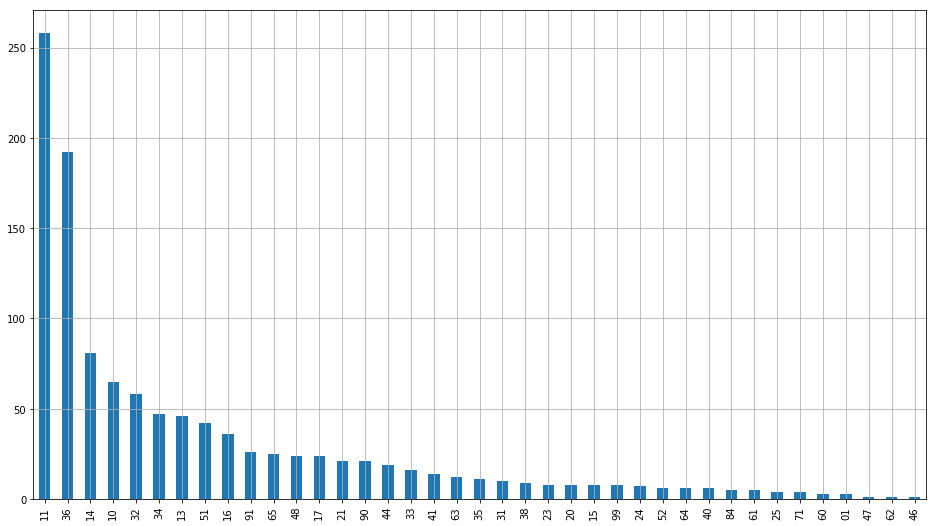

In [195]:
%matplotlib inline
pd_corpus.series.value_counts().plot(kind='bar', grid=True, figsize=(16, 9))

Tfidf

In [196]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#cf_vectorizer = CountVectorizer(max_df=0.90, min_df=5, stop_words='english',token_pattern = r'\b[a-zA-Z]{3,}\b')
#tf_vectorizer = TfidfVectorizer(max_df=0.70, min_df=20, max_features=10000, token_pattern=u'\w{3,}', ngram_range=(1,4))
tf_vectorizer = TfidfVectorizer(max_df=0.70, min_df=20, max_features=10000, tokenizer=tokenize_doc)
dtm_tf = tf_vectorizer.fit_transform(list(pd_corpus['contents']))

In [197]:
dtm_tf.shape

(1141, 10000)

Map tokens to tfidf values

In [198]:
tfidf_d = dict(zip(tf_vectorizer.get_feature_names(), tf_vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf_d), orient='index')
tfidf.columns = ['tfidf']

In [199]:
#tfidf.tfidf.hist(bins=50, figsize=(15,7))

In [200]:
# get feature names
features = tf_vectorizer.get_feature_names()



In [201]:
# Get top features for a given document (doc_num)
def top_feats_in_doc(term_matrix, features, doc_num, top_n=20):
    def top_tfidf_feats(row, features, top_n=25):
    
        topn_ids = np.argsort(row)[::-1][:top_n]
        top_feats = [(features[i], row[i]) for i in topn_ids]
        df = pd.DataFrame(top_feats)
        df.columns = ['feature', 'tfidf']
        return df

    row = np.squeeze(term_matrix[doc_num].toarray())  # convert sparse to dense
    # convert df to list of dicts
    #return [{'name':list(k)[0],'fv':list(k)[1]} for k in top_tfidf_feats(row, features, top_n).values]
    return top_tfidf_feats(row, features, top_n)

In [202]:
corpus[3]

{'contents': "BY ORDER OF THE SECRETARY OF THE AIR FORCE AIR FORCE INSTRUCTION 51-1201 17 MARCH 2014 Law CONFLICT MANAGEMENT AND ALTERNATIVE DISPUTE RESOLUTION IN WORKPLACE DISPUTES COMPLIANCE WITH THIS PUBLICATION IS MANDATORY ACCESSIBILITY: Publications and forms are available on the e-Publishing website at www.e-publishing.af.mil for download or ordering. RELEASABILITY: There are no releasability restrictions on this publication. OPR: SAF/GCD Supersedes: AFI 51-1201, 21 May 2009 Certified by: SAF/PDGC (Joseph M. McDade, Jr.) Pages: 37 This instruction implements Air Force Policy Directive 51-12, Alternative Dispute Resolution, and Department of Defense Directive 5145.5, Alternative Dispute Resolution. It prescribes the Air Force Alternative Dispute Resolution (ADR) program and procedures for resolving disputes in the Air Force workplace. It assigns responsibility for carrying out the program at Headquarters, Major Commands (MAJCOMs), Direct Reporting Units (DRUs), Field Operating Ag

In [203]:
def get_top_feats_as_array(dtm_tf, featurenames, doc_position, top_num=10):
    return [k for k in top_feats_in_doc(dtm_tf, featurenames,doc_position, top_n=10).sort_values(by=['tfidf'], ascending=False)['feature']]    

In [212]:
# 20 lowest
tfidf.sort_values(by=['tfidf'], ascending=True).head(20)

,tfidf
develop,1.358428
until,1.360937
programs,1.362194
"training,",1.362194
forward,1.364713
work,1.365975
"operations,",1.365975
equipment,1.367238
instruction.,1.367238
"33-360,",1.367238


In [213]:
# 20 highest
tfidf.sort_values(by=['tfidf'], ascending=False).head(20)

,tfidf
child’s,4.996014
cross-servicing,4.996014
tubes,4.996014
nepa,4.996014
patient's,4.996014
converter,4.996014
clients,4.996014
tacs,4.996014
chapel,4.996014
rations,4.996014


In [206]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

In [207]:
# SVD + TSNE for 2D
svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(dtm_tf)

tsne_model2 = TSNE(n_components=2, verbose=1, random_state=0)
tsne_tfidf2 = tsne_model2.fit_transform(svd_tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1141 samples in 0.002s...
[t-SNE] Computed neighbors for 1141 samples in 0.099s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1141
[t-SNE] Computed conditional probabilities for sample 1141 / 1141
[t-SNE] Mean sigma: 0.195009
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.890839
[t-SNE] Error after 1000 iterations: 0.830110


In [208]:
tfidf_df2 = pd.DataFrame(tsne_tfidf2, columns=['x', 'y'])
tfidf_df2['fname'] = pd_corpus['fname']
tfidf_df2['series'] = pd_corpus['series']
tfidf_df2['topfeats'] = [get_top_feats_as_array(dtm_tf, features,num) for num in range(0,len(pd_corpus))]


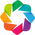

In [209]:
import holoviews as hv
hv.extension('bokeh')

In [215]:
tfidf_df2.to_csv('tfidf_tsne2.csv')

In [210]:
%%opts Scatter [color_index=2, width=1400 height=900 tools=['hover']] (size=10)

hv.Scatter(tfidf_df2, kdims=['x'], vdims=['y','series','fname','topfeats'])

:Scatter   [x]   (y,series,fname,topfeats)

In [226]:
num_series = len(set(list(tfidf_df2['series'].values)))

In [216]:
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot

init_notebook_mode(connected=True)

#x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 400).transpose()

iplot([go.Scatter(x=tfidf_df2['x'],
                    y=tfidf_df2['y'],
                    text=tfidf_df2['topfeats'],
                    mode='markers',
                    marker=dict(size='4',
                               color = tfidf_df2['series'],
                               colorscale='Jet',
                               showscale=True)
                    )])

In [227]:
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters=num_series)

In [242]:
kout = kmeans.fit(tsne_tfidf2)

In [243]:
kout

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=39, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [248]:
# mesh size step
h = 0.05
x_min, x_max = tsne_tfidf2[:, 0].min() - 1, tsne_tfidf2[:, 0].max() + 1
y_min, y_max = tsne_tfidf2[:, 1].min() - 1, tsne_tfidf2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [249]:
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

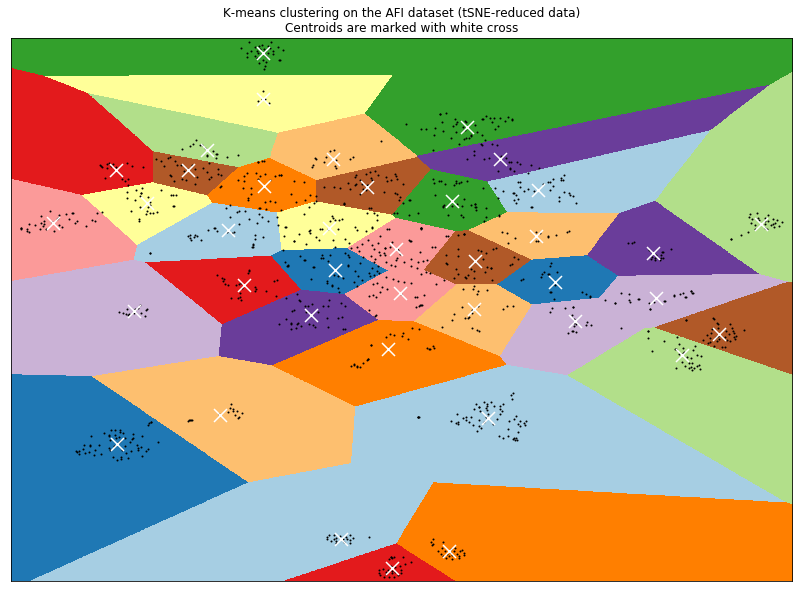

In [260]:
import matplotlib.pyplot as plt
Z = Z.reshape(xx.shape)
plt.figure(figsize=(14,10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(tsne_tfidf2[:, 0], tsne_tfidf2[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the AFI dataset (tSNE-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [259]:
%%opts Scatter [color_index=2, width=1400 height=900 tools=['hover']] (size=10)

hv.Scatter(tfidf_df2, kdims=['x'], vdims=['y','series','fname','topfeats'])

(2506, 1576)

In [230]:
# SVD + TSNE for 3D
svd3 = TruncatedSVD(n_components=40, random_state=0)
svd_tfidf3 = svd3.fit_transform(dtm_tf)

In [46]:
tsne_model3 = TSNE(n_components=3, verbose=1, n_iter=1000, random_state=0, perplexity=10)
tsne_tfidf3 = tsne_model3.fit_transform(svd_tfidf)

tfidf_df3 = pd.DataFrame(tsne_tfidf3, columns=['x', 'y','z'])
tfidf_df3['fname'] = pd_corpus['fname']
tfidf_df3['series'] = pd_corpus['series']

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.428877
[t-SNE] KL divergence after 250 iterations with early exaggeration: 125.398430
[t-SNE] Error after 1000 iterations: 4.901044


In [47]:
# SVD to 500, then PCA to 3
from sklearn.decomposition import PCA

_svd = TruncatedSVD(n_components=500, random_state=0)
_svd_tfidf = _svd.fit_transform(dtm_tf)

pca_model3d = PCA(n_components=3)
tfidf_pca3d = pca_model3d.fit_transform(_svd_tfidf)

tfidf_pca_df3 = pd.DataFrame(tfidf_pca3d, columns=['x', 'y','z'])
tfidf_pca_df3['fname'] = pd_corpus['fname']
tfidf_pca_df3['series'] = pd_corpus['series']

Viz for PCA 3d

In [48]:
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot

init_notebook_mode(connected=True)

#x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 400).transpose()

iplot([go.Scatter3d(x=tfidf_pca_df3['x'],
                    y=tfidf_pca_df3['y'],
                    z=tfidf_pca_df3['z'],
                    text=tfidf_pca_df3['fname'],
                    mode='markers',
                    marker=dict(size='4',
                               color = tfidf_pca_df3['series'],
                               colorscale='Jet',
                               showscale=True)
                    )])

In [49]:
_svd = TruncatedSVD(n_components=500, random_state=0)
_svd_tfidf = _svd.fit_transform(dtm_tf)

In [50]:
tsne_model3 = TSNE(n_components=3, verbose=1, random_state=0)
tsne_tfidf3 = tsne_model3.fit_transform(_svd_tfidf)

tfidf_df3 = pd.DataFrame(tsne_tfidf3, columns=['x', 'y','z'])
tfidf_df3['fname'] = pd_corpus['fname']
tfidf_df3['series'] = pd_corpus['series']

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.443637
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.892502
[t-SNE] Error after 1000 iterations: 1.710777


In [51]:
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot

init_notebook_mode(connected=True)

#x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 400).transpose()

iplot([go.Scatter3d(x=tfidf_df3['x'],
                  y=tfidf_df3['y'],
                    z=tfidf_df3['z'],
                    text=tfidf_df3['fname'],
                    mode='markers',
                    marker=dict(size='5',
                               color = tfidf_df3['series'],
                               colorscale='Jet',
                               showscale=True)
                    )])

Display LDA output

In [ ]:
#import pyLDAvis
#import pyLDAvis.sklearn
#pyLDAvis.enable_notebook()

#vis_data = pyLDAvis.sklearn.prepare(lda_model,dtm_tf,tf_vectorizer)
#pyLDAvis.display(vis_data)